# Skin Cancer Identification Model

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Data Mounting in google drive
from google.colab import drive
drive.mount('/content/gdrive')

#https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/My Drive/DATASETS/SKINCANCER/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/DATASETS/SKINCANCER/Test')

In [4]:
# Print the Number of Train and Test Images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("No.of Training Images:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("No. of Testing Images:",image_count_test)

No.of Training Images: 2239
No. of Testing Images: 118


**OPEN THE FIRST IMAGE**

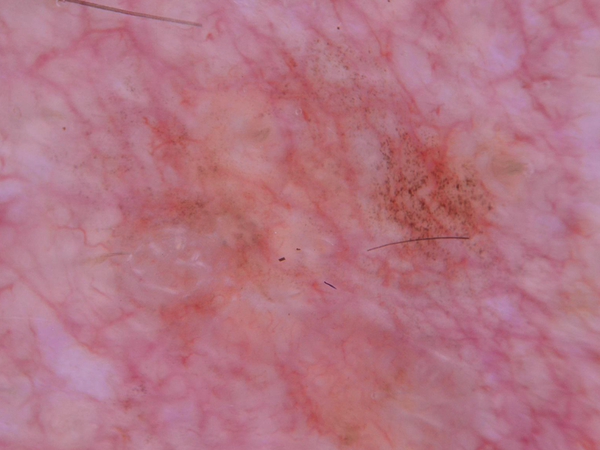

In [5]:
image1 = list(data_dir_train.glob('*/*.jpg'))
PIL.Image.open(str(image1[0]))

**Dataset Creation**

In [6]:
batch_size = 32
img_height = 180
img_width = 180

**Define Datasets with 80% for training, and 20% for validation.**

In [7]:
# Defining Training & Validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,shuffle=True,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,shuffle=True,validation_split=0.2,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Defining Testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(data_dir_test,shuffle=True,image_size=(img_height, img_width),batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# Class Names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the different Classes**

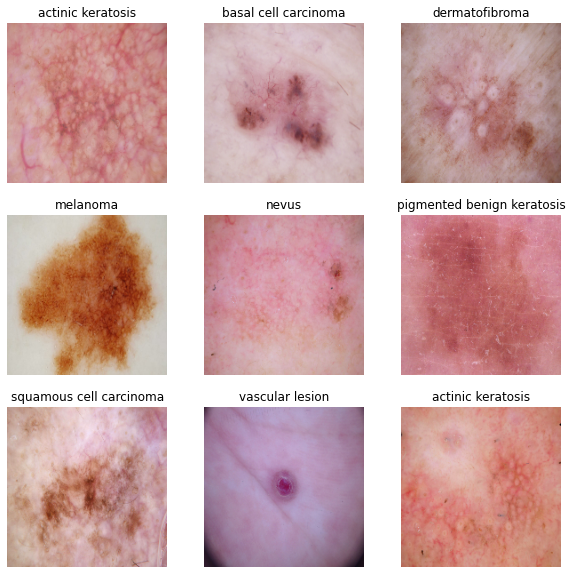

In [10]:
import matplotlib.pyplot as plt
j=0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for y in class_names:
    k=0
    for i in range(len(labels)):
      if j==9:
        break
      if y == class_names[labels[i]]:
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        j=j+1
        k=1
      if k==1:
        k=0
        break
      
    

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**Data Normalization**

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normtrain_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normval_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normtrain_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
normtrain_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
normtrain_ds = normtrain_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
normval_ds = normval_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Define the Model Layers**

In [15]:
num_classes = 9

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.BatchNormalization() ,
    tf.keras.layers.Dense(9,activation='softmax')
])

**Define the Model Parameters**

In [52]:
learning_rate = 0.001
epochs=50
opt= tf.keras.optimizers.Adam(learning_rate=learning_rate , decay=learning_rate/(epochs*0.5))

**Compile the Model**

In [53]:
model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])


In [54]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 88, 88, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 128)       7

**Train the model**

In [55]:
history=model.fit(
  normtrain_ds,
  validation_data=normval_ds,
  epochs=epochs
)

Epoch 1/50
56/56 [==============================] - 6s 98ms/step - loss: 0.4375 - accuracy: 0.8594 - val_loss: 7.7934 - val_accuracy: 0.2685
Epoch 2/50
56/56 [==============================] - 5s 95ms/step - loss: 0.2961 - accuracy: 0.9090 - val_loss: 4.2231 - val_accuracy: 0.3132
Epoch 3/50
56/56 [==============================] - 5s 96ms/step - loss: 0.1771 - accuracy: 0.9436 - val_loss: 6.5950 - val_accuracy: 0.2103
Epoch 4/50
56/56 [==============================] - 5s 96ms/step - loss: 0.0865 - accuracy: 0.9732 - val_loss: 2.3418 - val_accuracy: 0.4340
Epoch 5/50
56/56 [==============================] - 5s 97ms/step - loss: 0.0834 - accuracy: 0.9738 - val_loss: 3.2665 - val_accuracy: 0.3781
Epoch 6/50
56/56 [==============================] - 6s 99ms/step - loss: 0.0619 - accuracy: 0.9821 - val_loss: 4.8281 - val_accuracy: 0.2550
Epoch 7/50
56/56 [==============================] - 5s 97ms/step - loss: 0.0306 - accuracy: 0.9888 - val_loss: 3.1281 - val_accuracy: 0.4787
Epoch 8/50
56

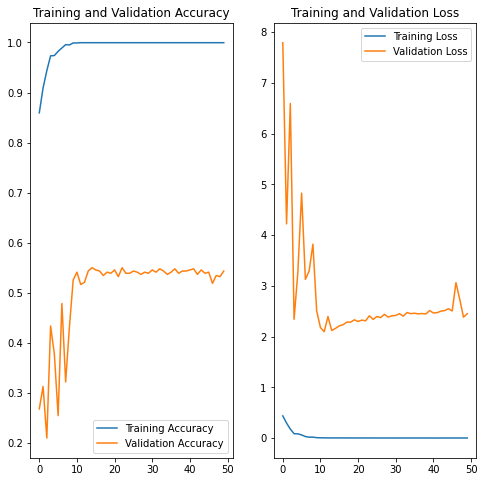

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
test_normalization_layer = tf.keras.layers.Rescaling(1./255)

test_normalized_ds = test_ds.map(lambda x, y: (test_normalization_layer(x), y))
test_image_batch, test_labels_batch = next(iter(test_normalized_ds))
test_first_image = test_image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(test_first_image), np.max(test_first_image))

0.23284315 0.8632347


In [58]:
score = model.evaluate(test_normalized_ds, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 4.815126419067383
Test accuracy: 0.35593220591545105


**Model Findings:-**

It is Observed that without applying Dropout layer in the Network architecture we can see a huge gap between the training accuracy and validation acccuracy. Model starts overfitting within 10 epochs and the test prediction results will be low

**Create the model with Data Augmentation and Dropout layer**

In [59]:
#Defining Data Augmentation Layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(factor=0.1,fill_mode='wrap'),
  tf.keras.layers.RandomZoom(.1, .1),
  tf.keras.layers.RandomContrast(factor=.1),
])

In [66]:
# Data Augmentation and Dropout layer added to the network
model2 = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(180, 180, 3)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(axis=-1),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(axis=-1),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512,activation='relu'),
  tf.keras.layers.BatchNormalization() ,
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Dense(9,activation='softmax')
  
])

**Compiling the model**

In [67]:
model2.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

**Training the model**

In [68]:
history2=model2.fit(normtrain_ds,validation_data=normval_ds,epochs=epochs)

Epoch 1/50


56/56 [==============================] - 13s 166ms/step - loss: 2.3510 - accuracy: 0.3644 - val_loss: 10.8876 - val_accuracy: 0.0694
Epoch 2/50
56/56 [==============================] - 10s 172ms/step - loss: 1.5707 - accuracy: 0.4671 - val_loss: 2.6189 - val_accuracy: 0.1320
Epoch 3/50
56/56 [==============================] - 9s 159ms/step - loss: 1.4347 - accuracy: 0.4927 - val_loss: 2.5269 - val_accuracy: 0.1588
Epoch 4/50
56/56 [==============================] - 9s 161ms/step - loss: 1.4068 - accuracy: 0.5061 - val_loss: 1.9229 - val_accuracy: 0.3132
Epoch 5/50
56/56 [==============================] - 9s 159ms/step - loss: 1.3148 - accuracy: 0.5352 - val_loss: 1.7078 - val_accuracy: 0.3714
Epoch 6/50
56/56 [==============================] - 9s 156ms/step - loss: 1.2833 - accuracy: 0.5474 - val_loss: 6.8236 - val_accuracy: 0.1924
Epoch 7/50
56/56 [==============================] - 9s 159ms/step - loss: 1.2770 - accuracy: 0.5312 - val_loss: 1.9400 - val_accuracy: 0.3937
Epoch 8/50
56/

**Visualizing the results with Augmentation & Dropout layer**

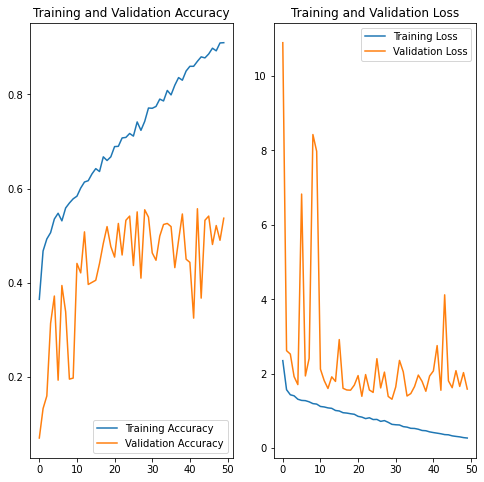

In [69]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
score2 = model2.evaluate(test_normalized_ds, verbose = 0) 

print('Test loss:', score2[0]) 
print('Test accuracy:', score2[1])

Test loss: 3.563832998275757
Test accuracy: 0.41525423526763916


**Model Findings**

By applying dropout layer in the network, early overfitting of model is being avoided, but as the number of epochs increases the model starts over fitting.

**Identifying Class Imbalance**

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [71]:
## Your code goes here.
a=0; b=0; c=0; d=0; e=0; f=0; g=0; h=0; m=0; t=0

for images, labels in train_ds:
  for i in range(len(labels)):
    if (class_names[labels[i]]==class_names[0]):
      a=a+1
    elif (class_names[labels[i]]==class_names[1]):
      b=b+1
    elif (class_names[labels[i]]==class_names[2]):
      c=c+1
    elif (class_names[labels[i]]==class_names[3]):
      d=d+1
    elif (class_names[labels[i]]==class_names[4]):
      e=e+1
    elif (class_names[labels[i]]==class_names[5]):
      f=f+1
    elif (class_names[labels[i]]==class_names[6]):
      g=g+1
    elif (class_names[labels[i]]==class_names[7]):
      h=h+1
    else:
      m=m+1
    
t=a+b+c+d+e+f+g+h+m
ap=a/t*100; bp=b/t*100; cp=c/t*100; dp=d/t*100; ep=e/t*100; fp=f/t*100; gp=g/t*100; hp=h/t*100; mp=m/t*100
print(class_names[0], "\t\t:","%.2f"%ap)
print(class_names[1], "\t\t:","%.2f"%bp)
print(class_names[2], "\t\t\t:","%.2f"%cp)
print(class_names[3], "\t\t\t:","%.2f"%dp)
print(class_names[4], "\t\t\t\t:","%.2f"%ep)
print(class_names[5], "\t:","%.2f"%fp)
print(class_names[6], "\t\t:","%.2f"%gp)
print(class_names[7], "\t:","%.2f"%hp)
print(class_names[8], "\t\t:","%.2f"%mp)

actinic keratosis 		: 5.13
basal cell carcinoma 		: 17.24
dermatofibroma 			: 4.30
melanoma 			: 19.64
nevus 				: 15.46
pigmented benign keratosis 	: 20.65
seborrheic keratosis 		: 3.24
squamous cell carcinoma 	: 7.92
vascular lesion 		: 6.42


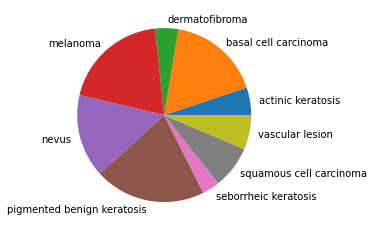

In [143]:
yc=np.array([ap,bp,cp,dp,ep,fp,gp,hp,mp])
yc_labels=class_names
plt.pie(yc,labels=yc_labels)
plt.show()

**Class Distribution:**
By calculating the % of each class in the training dataset, we can see that "Seborrheic keratosis" has least numbers, followed by "dermatofibroma", "actinic keratosis", "vasular lesion","squamous cell carcinoma", "nevus", "basal cell carcinoma", "melanoma" and "pigmented benign keratosis".

**Class Domination:**
Four classes namely Pigmented Benign keratosis, Melanoma, Basal Cell carcinoma and Nevus occupy nearly 72.9% of the training dataset

**AUGMENTOR INSTALL**

In [72]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Linking Training dataset to Augmentor To Generate 500 samples in each class**

In [73]:
path_to_training_dataset=pathlib.Path('/content/gdrive/My Drive/DATASETS/SKINCANCER/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/"+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/DATASETS/SKINCANCER/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F986727C990>: 100%|██████████| 500/500 [00:18<00:00, 26.98 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/DATASETS/SKINCANCER/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F98662DB110>: 100%|██████████| 500/500 [00:17<00:00, 28.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/DATASETS/SKINCANCER/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F986720D150>: 100%|██████████| 500/500 [00:18<00:00, 26.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/DATASETS/SKINCANCER/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F986727C990>: 100%|██████████| 500/500 [01:25<00:00,  5.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/DATASETS/SKINCANCER/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F9867740310>: 100%|██████████| 500/500 [01:17<00:00,  6.49 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/DATASETS/SKINCANCER/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9868E1D690>: 100%|██████████| 500/500 [00:17<00:00, 28.23 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/DATASETS/SKINCANCER/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9868CA6710>: 100%|██████████| 500/500 [00:40<00:00, 12.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/DATASETS/SKINCANCER/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98D40AA550>: 100%|██████████| 500/500 [00:19<00:00, 25.32 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/DATASETS/SKINCANCER/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9868EC7310>: 100%|██████████| 500/500 [00:20<00:00, 24.74 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [74]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [75]:
path_list_new = [x for x in data_dir_train.glob('*/output/*.jpg')]


In [76]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]


In [77]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [78]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [79]:
df2['Label'].value_counts()

actinic keratosis             500
nevus                         500
basal cell carcinoma          500
seborrheic keratosis          500
pigmented benign keratosis    500
melanoma                      500
dermatofibroma                500
vascular lesion               500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [80]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training and Validation dataset with Augmented data**

In [84]:
data_dir_train='/content/gdrive/My Drive/DATASETS/SKINCANCER/Train'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,shuffle=True,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,shuffle=True,validation_split=0.2,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Data Normalization and Model configuration**

In [85]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normtrain_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normval_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normtrain_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.14509997 0.85065395


In [90]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
normtrain_ds = normtrain_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
normval_ds = normval_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [136]:
#Defining Data Augmentation Layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(factor=0.1,fill_mode='wrap'),
  tf.keras.layers.RandomZoom(.1, .1),
  tf.keras.layers.RandomContrast(factor=.1),
])

In [137]:
# Data Augmentation and Dropout layer added to the network
model3 = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(180, 180, 3)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(axis=-1),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(axis=-1),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512,activation='relu'),
  tf.keras.layers.BatchNormalization() ,
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Dense(9,activation='softmax')
  
])

**Compile the model**

In [138]:
model3.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

**Train the model with Augmented data**

In [139]:
history3=model3.fit(normtrain_ds,validation_data=normval_ds,epochs=epochs)

Epoch 1/50


43/43 [==============================] - 11s 168ms/step - loss: 2.5692 - accuracy: 0.2353 - val_loss: 5.0634 - val_accuracy: 0.0883
Epoch 2/50
43/43 [==============================] - 7s 159ms/step - loss: 1.7694 - accuracy: 0.3556 - val_loss: 2.6544 - val_accuracy: 0.1292
Epoch 3/50
43/43 [==============================] - 7s 163ms/step - loss: 1.5944 - accuracy: 0.4172 - val_loss: 2.8859 - val_accuracy: 0.1418
Epoch 4/50
43/43 [==============================] - 7s 158ms/step - loss: 1.5092 - accuracy: 0.4402 - val_loss: 2.9884 - val_accuracy: 0.1106
Epoch 5/50
43/43 [==============================] - 7s 156ms/step - loss: 1.4986 - accuracy: 0.4447 - val_loss: 2.9824 - val_accuracy: 0.1418
Epoch 6/50
43/43 [==============================] - 7s 157ms/step - loss: 1.3881 - accuracy: 0.4692 - val_loss: 2.5982 - val_accuracy: 0.1411
Epoch 7/50
43/43 [==============================] - 7s 157ms/step - loss: 1.3410 - accuracy: 0.4996 - val_loss: 2.4746 - val_accuracy: 0.1685
Epoch 8/50
43/43

**Visualize the model results**

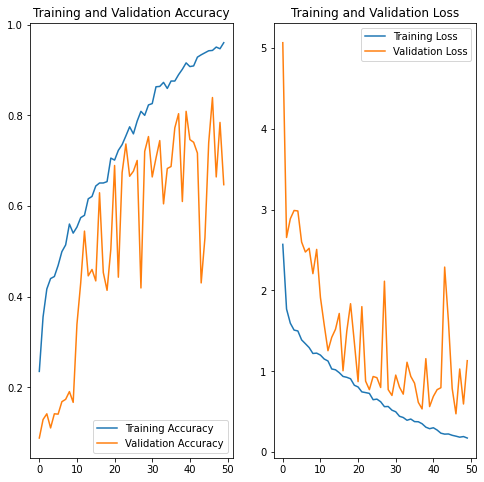

In [140]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Results Analysis**:
With the help of Data Augmentation, the gap between training and validation accuracy had reduced drastically with better validation accuracy scores

In [129]:
test_normalization_layer = tf.keras.layers.Rescaling(1./255)

test_normalized_ds = test_ds.map(lambda x, y: (test_normalization_layer(x), y))

In [130]:
score3 = model3.evaluate(test_normalized_ds, verbose = 0) 

print('Test loss:', score3[0]) 
print('Test accuracy:', score3[1])

Test loss: 3.691706657409668
Test accuracy: 0.3305084705352783
